In [1]:
print("Starting imports...")
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float64, complex128
from numba.cuda import jit as cuda_jit
import math

print("Importing few...")
import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum 


from few.utils.ylm import GetYlms

from few import get_file_manager

from few.waveform import FastKerrEccentricEquatorialFlux

from few.utils.geodesic import get_fundamental_frequencies

import os
import sys

# Change to the desired directory
os.chdir('/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

# Add it to Python path
sys.path.insert(0, '/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

print("Importing GWfuncs...")
import GWfuncs
# import gc
# import pickle
print("Importing cupy...")
import cupy as cp

print("Configuring few...")
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info")

# print("Importing dynesty...")
# import dynesty

Starting imports...
Importing few...
Importing GWfuncs...
Importing cupy...
Configuring few...


In [2]:
from lisatools.sensitivity import *


In [3]:
for backend in ["cpu", "cuda11x", "cuda12x", "cuda", "gpu"]: 
    print(f" - Backend '{backend}': {"available" if few.has_backend(backend) else "unavailable"}")  

 - Backend 'cpu': available
 - Backend 'cuda11x': unavailable
 - Backend 'cuda12x': available
 - Backend 'cuda': available
 - Backend 'gpu': available


In [4]:
from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI


In [37]:
N_traj = 1e4 # change amount of points here 
T = 1 #yr
delta_T = T*YRSID_SI/N_traj 

In [38]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
xI0 = 1.0 
dist= 1
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
traj = EMRIInspiral(func=KerrEccEqFlux, npoints=N_traj) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")
gwf = GWfuncs.GravWaveAnalysis(T=T, dt=dt)

In [39]:
factor = gwf.dist_factor(dist, m2)

In [40]:
indices = [1165, 1166, 7159, 1164, 7160]

In [41]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [42]:
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=delta_T, upsample=True) 
teuk_modes = amp(a, p, e, x)


In [43]:
t_gpu = cp.asarray(t)
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

In [44]:
mode_labels_per_mode = [mode_labels[idx] for idx in indices]
print(mode_labels_per_mode)

['(2,2,0)', '(2,2,1)', '(2,-2,0)', '(2,2,-1)', '(2,-2,1)']


In [45]:
use_gpu = True
force_backend = "cuda12x"  
print("Setting up waveform generator...")
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": False, 
        "use_gpu" : use_gpu,
        "force_backend":force_backend
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": force_backend,
    # "use_gpu" : use_gpu
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": force_backend,
    # "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend":force_backend,
    "pad_output": True,
    "separate_modes": True
    # "use_gpu" : use_gpu
}

print("Creating FastKerrEccentricEquatorialFlux...")
# Kerr eccentric flux
waveform_gen = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

Setting up waveform generator...
Creating FastKerrEccentricEquatorialFlux...


In [46]:
pos_mode =  [(2,2,0)]
neg_mode =  [(2,-2,0)]

In [47]:
h_pos = waveform_gen(
    m1, 
    m2,
    a, 
    p0, 
    e0, 
    xI0, 
    theta, 
    phi, 
    dist=dist, 
    dt=dt, 
    T=1, 
    mode_selection=pos_mode,
    include_minus_mkn=False,
)


In [48]:
h_pos

array([[2.10318780e-23+7.62786108e-23j],
       [3.07539570e-23+7.29037799e-23j],
       [3.99557977e-23+6.82956943e-23j],
       ...,
       [4.47886261e-23-8.50784594e-23j],
       [3.04281609e-23-9.12057770e-23j],
       [1.52653241e-23-9.49280679e-23j]])

In [49]:
h_neg = waveform_gen(
    m1, 
    m2,
    a, 
    p0, 
    e0, 
    xI0, 
    theta, 
    phi, 
    dist=dist, 
    dt=dt, 
    T=1, 
    mode_selection=neg_mode,
    include_minus_mkn=False,
)


/scratch/e1498138/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


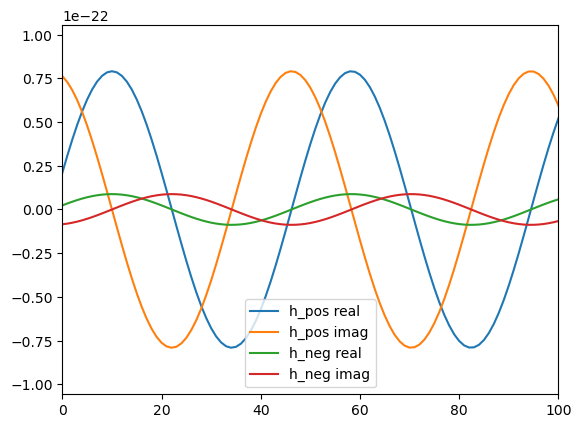

In [50]:
# plt.plot(waveform_per_mode[0].get().real, label=mode_labels_per_mode[0])
# plt.plot(waveform_per_mode[0].get().imag, label=mode_labels_per_mode[0])
plt.plot(h_pos.get().real, label="h_pos real")
plt.plot(h_pos.get().imag, label="h_pos imag")
plt.plot(h_neg.get().real, label="h_neg real")
plt.plot(h_neg.get().imag, label="h_neg imag")
plt.legend()
plt.xlim(0,1e2)
plt.show()

In [51]:
h_pos.shape, h_neg.shape

((3155815, 1), (3155815, 1))

In [52]:
h_pos_f = gwf.freq_wave(h_pos[:,0])
h_neg_f = gwf.freq_wave(h_neg[:,0])
h_pos_f.shape, h_neg_f.shape

((2, 1577908), (2, 1577908))

In [53]:
gwf.overlap(h_pos_f, h_neg_f) 

array(-1.10222856e-05)

In [54]:
def calc_inner(idx_i, idx_j, teuk_modes, amp, freqs, phases, delta_T, factor):
    # Obtain the lmn-s
    l_i = amp.l_arr[idx_i]
    m_i = amp.m_arr[idx_i]
    n_i = amp.n_arr[idx_i]

    l_j = amp.l_arr[idx_j]
    m_j = amp.m_arr[idx_j]
    n_j = amp.n_arr[idx_j]

    # Get Teukolsky modes
    # Check if negative m 
    if m_i >= 0:
        A_i = teuk_modes[:, idx_i]

    elif m_i < 0:
        pos_m_mask_i = (amp.l_arr == l_i) & (amp.m_arr == -m_i) & (amp.n_arr == -n_i)
        pos_m_idx_i = np.where(pos_m_mask_i)[0]
        A_i_pos = teuk_modes[:, pos_m_idx_i]
        A_i = (-1)**l_i * np.conj(A_i_pos)

    if m_j >= 0:
        A_j = teuk_modes[:, idx_j]
        
    elif m_j < 0:
        pos_m_mask_j = (amp.l_arr == l_j) & (amp.m_arr == -m_j) & (amp.n_arr == -n_j)
        pos_m_idx_j = np.where(pos_m_mask_j)[0]
        A_j_pos = teuk_modes[:, pos_m_idx_j]
        A_j = (-1)**l_j * np.conj(A_j_pos)

    # Get sensitivity for each mode 
    Sn_i = get_sensitivity(freqs[idx_i], sens_fn=LISASens, return_type="PSD")
    Sn_j = get_sensitivity(freqs[idx_j], sens_fn=LISASens, return_type="PSD")

    # Get noise-weighted amplitudes
    bar_A_i = A_i.get() / np.sqrt(Sn_i)
    bar_A_j = A_j.get() / np.sqrt(Sn_j)

    # Get phase mask
    phase_mask = np.abs(phases[idx_i] - phases[idx_j]) < 1.0 

    # Calculate product
    prod = np.conj(bar_A_i[phase_mask]) * bar_A_j[phase_mask]

    # Calculate full inner product
    innerprod = np.sum(np.real(prod)) * delta_T * 1/(factor**2)

    return innerprod

In [55]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x) #could use GPU here but im running to mismatch probs
#actually whats the benefit of running cpu -> convert gpu vs running all in gpu in the first place?

In [56]:
l_cpu = amp.l_arr.get()
m_cpu = amp.m_arr.get()
n_cpu = amp.n_arr.get()

In [57]:
gw_frequencies_per_mode = []

for idx in range(len(mode_labels)):
    # TODO: do convert this so everything is in either CPU/GPU?
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)

In [58]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]

    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

In [59]:
# (2,2,0) & (2,-2,0)
cross_inner = calc_inner(1165,7159, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
cross_inner

array(643.25010388)

In [60]:
SNR_pos = np.sqrt(calc_inner(1165,1165, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor))
SNR_pos

array(28.6212423)

In [61]:
SNR_neg = np.sqrt(calc_inner(7159,7159, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor))
SNR_neg

array(2880.30621122)

In [62]:
cross_inner/(SNR_pos * SNR_neg)

array(0.00780284)

In [69]:
teuk_modes.shape

(10000, 6993)

In [76]:
waveform_per_mode = []
for idx in indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    print(f"Processing mode {mode_labels[idx]}: (l={l}, m={m}, n={n})")

    if m >= 0:
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
        n_arr = amp.n_arr[[idx]]
    else:
        print(f"Negative m for mode {mode_labels[idx]}, using positive m counterpart.")
        pos_m_mask = (amp.l_arr == l) \
                    & (amp.m_arr == -m) \
                    & (amp.n_arr == -n)
        pos_m_idx = int(gwf.xp.where(pos_m_mask)[0][0])
        print(f"Using positive m index: {mode_labels[pos_m_idx]} for mode {mode_labels[idx]}")
        teuk_modes_single = (-1)**l * gwf.xp.conj(teuk_modes[:, [pos_m_idx]])
        ylms_single = ylms[[idx]]
        m_arr = gwf.xp.abs(amp.m_arr[[idx]]) 
        n_arr = gwf.xp.abs(amp.n_arr[[idx]])

    waveform = interpolate_mode_sum(
        t_gpu, teuk_modes_single, ylms_single,
        traj.integrator_spline_t, traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], m_arr, n_arr, 
        dt=dt, T=T
    )
    waveform_per_mode.append(waveform / factor)


Processing mode (2,2,0): (l=2, m=2, n=0)
Processing mode (2,2,1): (l=2, m=2, n=1)
Processing mode (2,-2,0): (l=2, m=-2, n=0)
Negative m for mode (2,-2,0), using positive m counterpart.
Using positive m index: (2,2,0) for mode (2,-2,0)
Processing mode (2,2,-1): (l=2, m=2, n=-1)
Processing mode (2,-2,1): (l=2, m=-2, n=1)
Negative m for mode (2,-2,1), using positive m counterpart.
Using positive m index: (2,2,-1) for mode (2,-2,1)


In [79]:
T

1

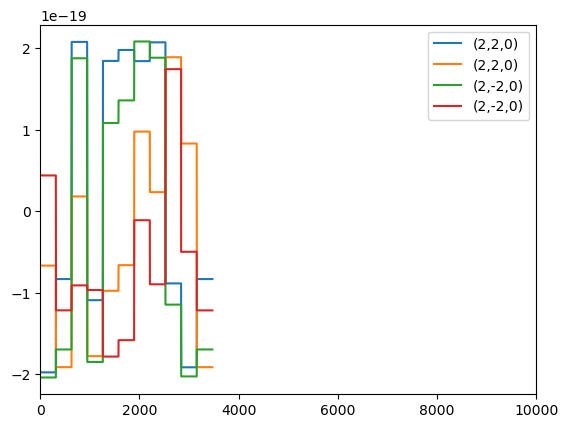

In [77]:
plt.plot(waveform_per_mode[0].get().real, label=mode_labels_per_mode[0])
plt.plot(waveform_per_mode[0].get().imag, label=mode_labels_per_mode[0])
plt.plot(waveform_per_mode[2].get().real, label=mode_labels_per_mode[2])
plt.plot(waveform_per_mode[2].get().imag, label=mode_labels_per_mode[2])
plt.legend()
plt.xlim(0,1e4)
plt.show()

In [75]:
pos_m_idx

array(1164)